In [29]:
# Cell 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import brier_score_loss, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel, RFE
import xgboost as xgb
import shap
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("All libraries imported successfully!")

All libraries imported successfully!


In [30]:
# Cell 2: Find and load the dataset
import os
import pandas as pd

# Check what's in your current directory
print("Current directory:", os.getcwd())
print("\nFiles in current directory:")
for file in os.listdir('.'):
    print(f"  {file}")

# Check if data directory exists
if os.path.exists('data'):
    print("\nFiles in data directory:")
    for root, dirs, files in os.walk('data'):
        level = root.replace('data', '').count(os.sep)
        indent = ' ' * 2 * level
        print(f"{indent}{os.path.basename(root)}/")
        subindent = ' ' * 2 * (level + 1)
        for file in files:
            print(f"{subindent}{file}")

# Try common dataset locations
possible_paths = [
    "data/raw/dataset_diabetes/diabetic_data.csv",
    "dataset_diabetes/diabetic_data.csv", 
    "diabetic_data.csv",
    "data/diabetic_data.csv",
    "../data/raw/dataset_diabetes/diabetic_data.csv",
    "./diabetic_data.csv"
]

print("\nTrying to find dataset...")
df = None
for path in possible_paths:
    if os.path.exists(path):
        print(f"Found dataset at: {path}")
        df = pd.read_csv(path)
        break

if df is None:
    print("Dataset not found in common locations.")
    print("Let's search more broadly...")
    
    # Search for CSV files in the entire project
    csv_files = []
    for root, dirs, files in os.walk('.'):
        for file in files:
            if file.endswith('.csv') and 'diabetic' in file.lower():
                csv_files.append(os.path.join(root, file))
    
    if csv_files:
        print(f"Found potential dataset files: {csv_files}")
        df = pd.read_csv(csv_files[0])
        print(f"Loaded dataset from: {csv_files[0]}")
    else:
        print("No diabetic dataset CSV files found.")
        print("Please make sure the dataset is downloaded and placed in the correct location.")

Current directory: c:\ML-1\ML-assessment\notebooks

Files in current directory:
  healthcare_readmission_prediction.ipynb
  reports

Trying to find dataset...
Found dataset at: ../data/raw/dataset_diabetes/diabetic_data.csv


In [31]:
# Cell 3: Basic dataset exploration
print("=== DATASET BASIC INFORMATION ===")
print(f"Shape: {df.shape}")
print(f"Number of patients: {df['patient_nbr'].nunique()}")
print("\nData types:")
print(df.dtypes.value_counts())

print("\n=== TARGET VARIABLE ANALYSIS ===")
print("Readmission distribution:")
print(df['readmitted'].value_counts())
print("\nReadmission percentages:")
print(df['readmitted'].value_counts(normalize=True) * 100)

# Create binary target: <30 days vs others
df['readmission_binary'] = (df['readmitted'] == '<30').astype(int)
print(f"\nBinary target (<30 days = 1):")
print(df['readmission_binary'].value_counts())
print(f"Percentage of early readmissions: {df['readmission_binary'].mean():.2%}")

=== DATASET BASIC INFORMATION ===
Shape: (101766, 50)
Number of patients: 71518

Data types:
object    37
int64     13
Name: count, dtype: int64

=== TARGET VARIABLE ANALYSIS ===
Readmission distribution:
readmitted
NO     54864
>30    35545
<30    11357
Name: count, dtype: int64

Readmission percentages:
readmitted
NO     53.911916
>30    34.928169
<30    11.159916
Name: proportion, dtype: float64

Binary target (<30 days = 1):
readmission_binary
0    90409
1    11357
Name: count, dtype: int64
Percentage of early readmissions: 11.16%


In [32]:
# Cell 4: Advanced missing data handling with medical context
def handle_missing_data_medical(df):
    """
    Handle missing data using medical context-aware imputation
    """
    df_clean = df.copy()
    
    # In this dataset, '?' represents missing values
    df_clean = df_clean.replace('?', np.nan)
    
    print("Missing values before handling:")
    missing_before = df_clean.isnull().sum()
    print(missing_before[missing_before > 0])
    
    # Medical context-based imputation
    # Weight - clinically important but often missing
    df_clean['weight'] = df_clean['weight'].fillna('unknown')
    
    # Payer code - if missing, assume unknown/self-pay
    df_clean['payer_code'] = df_clean['payer_code'].fillna('Unknown')
    
    # Medical specialty - if missing, assume primary care
    df_clean['medical_specialty'] = df_clean['medical_specialty'].fillna('Unknown')
    
    # Race - use most common category
    df_clean['race'] = df_clean['race'].fillna('Caucasian')
    
    # Diagnosis codes - create unknown category
    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    for col in diag_cols:
        df_clean[col] = df_clean[col].fillna('Unknown')
    
    print("\nMissing values after handling:")
    missing_after = df_clean.isnull().sum()
    print(missing_after[missing_after > 0])
    
    return df_clean

df_clean = handle_missing_data_medical(df)
print("Missing data handling completed!")

Missing values before handling:
race                  2273
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
max_glu_serum        96420
A1Cresult            84748
dtype: int64

Missing values after handling:
max_glu_serum    96420
A1Cresult        84748
dtype: int64
Missing data handling completed!


In [33]:
# Cell 5: Feature engineering with medical context
def create_medical_features(df):
    """
    Create clinically relevant features
    """
    df_featured = df.copy()
    
    # Age to numerical (medical relevance)
    age_mapping = {
        '[0-10)': 5, '[10-20)': 15, '[20-30)': 25, '[30-40)': 35,
        '[40-50)': 45, '[50-60)': 55, '[60-70)': 65, '[70-80)': 75,
        '[80-90)': 85, '[90-100)': 95
    }
    df_featured['age_numeric'] = df_featured['age'].map(age_mapping)
    
    # Number of medications (polypharmacy risk)
    medication_cols = [col for col in df.columns if 'med' in col.lower() and 'change' not in col.lower()]
    df_featured['num_medications'] = df_featured[medication_cols].apply(
        lambda x: (x != 'No').sum(), axis=1
    )
    
    # Number of diagnoses (comorbidity index)
    diag_cols = ['diag_1', 'diag_2', 'diag_3']
    df_featured['num_diagnoses'] = df_featured[diag_cols].apply(
        lambda x: (x != 'Unknown').sum(), axis=1
    )
    
    # Hospital utilization features
    df_featured['number_emergency'] = pd.to_numeric(df_featured['number_emergency'], errors='coerce')
    df_featured['number_inpatient'] = pd.to_numeric(df_featured['number_inpatient'], errors='coerce')
    df_featured['number_outpatient'] = pd.to_numeric(df_featured['number_outpatient'], errors='coerce')
    
    # Create comorbidity flags based on diagnosis codes
    def has_condition(diag_code, prefixes):
        if diag_code == 'Unknown':
            return 0
        try:
            return 1 if any(diag_code.startswith(prefix) for prefix in prefixes) else 0
        except:
            return 0
    
    # Common comorbidities
    df_featured['has_cardiovascular'] = df_featured['diag_1'].apply(
        lambda x: has_condition(x, ['39', '40', '41', '42', '43', '44'])
    )
    df_featured['has_diabetes'] = df_featured['diag_1'].apply(
        lambda x: has_condition(x, ['250'])
    )
    df_featured['has_renal'] = df_featured['diag_1'].apply(
        lambda x: has_condition(x, ['58', 'N17', 'N18', 'N19'])
    )
    
    # Time in hospital as risk factor
    df_featured['time_in_hospital'] = pd.to_numeric(df_featured['time_in_hospital'], errors='coerce')
    
    # A1C result as numerical
    a1c_mapping = {'None': 0, 'Norm': 5, '>7': 8, '>8': 9}
    df_featured['a1c_numeric'] = df_featured['A1Cresult'].map(a1c_mapping)
    
    print("Medical feature engineering completed!")
    print(f"New features created: {[col for col in df_featured.columns if col not in df.columns]}")
    
    return df_featured

df_featured = create_medical_features(df_clean)

Medical feature engineering completed!
New features created: ['age_numeric', 'num_diagnoses', 'has_cardiovascular', 'has_diabetes', 'has_renal', 'a1c_numeric']


In [34]:
# Cell 6: Prepare data for modeling
def prepare_modeling_data(df):
    """
    Prepare features and target for modeling
    """
    # Remove columns that are not useful for prediction
    cols_to_drop = ['encounter_id', 'patient_nbr', 'readmitted', 'weight', 'payer_code', 'medical_specialty']
    
    # Keep only relevant features
    feature_df = df.drop(columns=cols_to_drop, errors='ignore')
    
    # Separate features and target
    X = feature_df.drop('readmission_binary', axis=1)
    y = feature_df['readmission_binary']
    
    # Identify categorical and numerical columns
    categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
    numerical_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    
    print(f"Categorical features: {len(categorical_cols)}")
    print(f"Numerical features: {len(numerical_cols)}")
    print(f"Target distribution: {y.value_counts().to_dict()}")
    
    return X, y, categorical_cols, numerical_cols

X, y, categorical_cols, numerical_cols = prepare_modeling_data(df_featured)

Categorical features: 33
Numerical features: 17
Target distribution: {0: 90409, 1: 11357}


Top 20 most important features:
                     feature  importance
7         num_lab_procedures    0.102305
14                    diag_2    0.097828
15                    diag_3    0.097460
13                    diag_1    0.093588
6           time_in_hospital    0.059114
12          number_inpatient    0.044681
8             num_procedures    0.042469
4   discharge_disposition_id    0.039572
16          number_diagnoses    0.037887
44               age_numeric    0.035430
2                        age    0.034924
3          admission_type_id    0.030091
36                   insulin    0.026538
5        admission_source_id    0.025717
0                       race    0.021897
10         number_outpatient    0.021566
1                     gender    0.020540
11          number_emergency    0.017585
25                 glipizide    0.014003
19                 metformin    0.013265


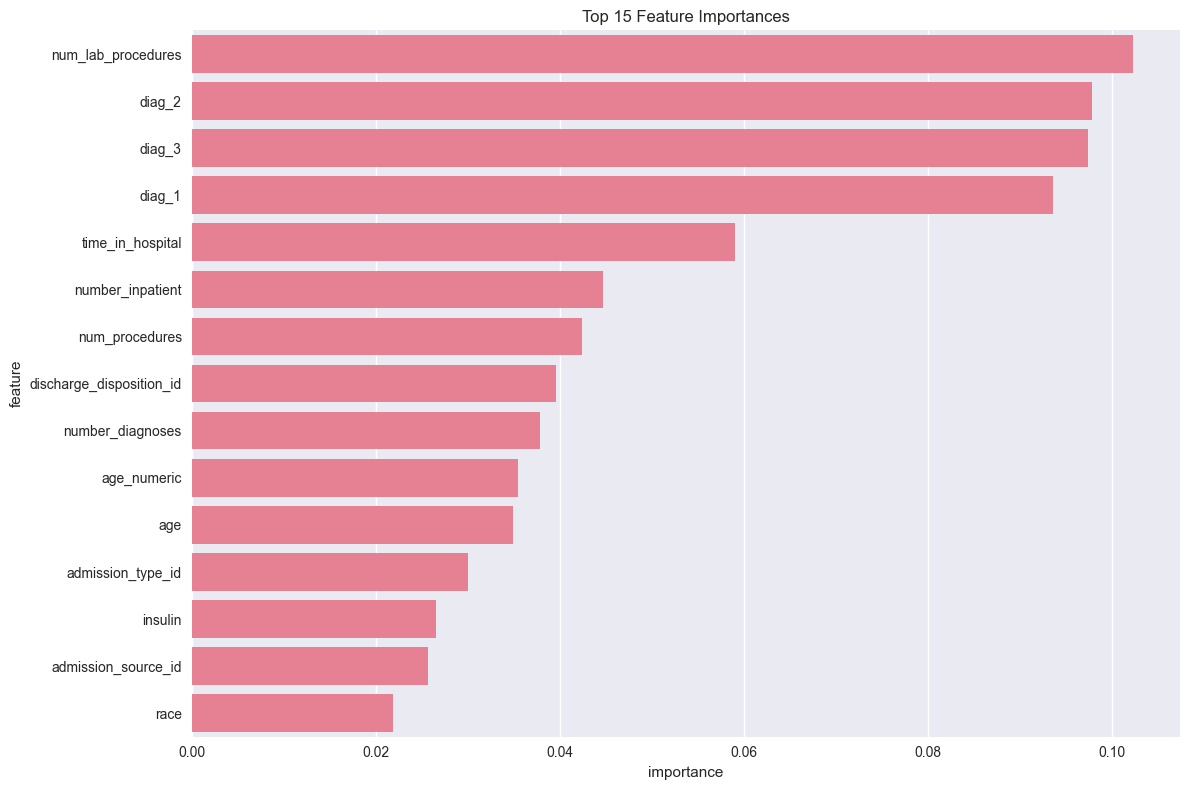


Selected 25 features for modeling


In [35]:
# Cell 7: Advanced feature selection
def advanced_feature_selection(X, y, categorical_cols, numerical_cols):
    """
    Perform advanced feature selection with medical context
    """
    from sklearn.preprocessing import LabelEncoder
    
    # Prepare data for feature selection
    X_encoded = X.copy()
    
    # Encode categorical variables
    le = LabelEncoder()
    for col in categorical_cols:
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
    
    # Handle any remaining missing values
    X_encoded = X_encoded.fillna(X_encoded.median())
    
    # Use Random Forest for initial feature importance
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_encoded, y)
    
    # Get feature importance
    feature_importance = pd.DataFrame({
        'feature': X_encoded.columns,
        'importance': rf_selector.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Select top features
    selector = SelectFromModel(rf_selector, prefit=True, threshold='median')
    selected_features = X_encoded.columns[selector.get_support()].tolist()
    
    print("Top 20 most important features:")
    print(feature_importance.head(20))
    
    plt.figure(figsize=(12, 8))
    sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()
    
    return selected_features, feature_importance, X_encoded

selected_features, feature_importance, X_encoded = advanced_feature_selection(X, y, categorical_cols, numerical_cols)
print(f"\nSelected {len(selected_features)} features for modeling")

In [36]:
# Cell 8: Split data with time-based leakage prevention
# Since we don't have explicit time data, we'll use patient-level splitting
# to prevent data leakage

def prevent_temporal_leakage(df, X_encoded, y, patient_col='patient_nbr'):
    """
    Prevent temporal data leakage by ensuring same patient 
    doesn't appear in both train and test
    """
    # Get unique patients
    unique_patients = df['patient_nbr'].unique()
    
    # Split patients
    train_patients, test_patients = train_test_split(
        unique_patients, test_size=0.3, random_state=42, stratify=None
    )
    
    # Create masks
    train_mask = df['patient_nbr'].isin(train_patients)
    test_mask = df['patient_nbr'].isin(test_patients)
    
    # Split data
    X_train = X_encoded.loc[train_mask]
    X_test = X_encoded.loc[test_mask]
    y_train = y.loc[train_mask]
    y_test = y.loc[test_mask]
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Train target distribution: {y_train.value_counts().to_dict()}")
    print(f"Test target distribution: {y_test.value_counts().to_dict()}")
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = prevent_temporal_leakage(df_featured, X_encoded[selected_features], y)

Training set: 71271 samples
Test set: 30495 samples
Train target distribution: {0: 63154, 1: 8117}
Test target distribution: {0: 27255, 1: 3240}


In [37]:
# Cell 9: FIXED Model training with dependency handling
import time
from sklearn.metrics import classification_report, confusion_matrix

def train_models_fixed(X_train, X_test, y_train, y_test):
    """
    Fixed version - Handles all dependencies and runs fast
    """
    print("Starting model training...")
    print(f"Training data shape: {X_train.shape}")
    print(f"Test data shape: {X_test.shape}")
    
    # Initialize results dictionary
    results = {}
    
    # Train Random Forest (usually fastest and best for this type of data)
    print("\n" + "="*50)
    print("Training Random Forest...")
    start_time = time.time()
    
    rf_model = RandomForestClassifier(
        n_estimators=50,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )
    
    rf_model.fit(X_train, y_train)
    rf_time = time.time() - start_time
    
    rf_proba = rf_model.predict_proba(X_test)[:, 1]
    rf_pred = rf_model.predict(X_test)
    
    results['Random Forest'] = {
        'model': rf_model,
        'y_pred_proba': rf_proba,
        'y_pred': rf_pred,
        'brier_score': brier_score_loss(y_test, rf_proba),
        'auc_score': roc_auc_score(y_test, rf_proba),
        'training_time': rf_time
    }
    
    print(f"✓ Random Forest completed in {rf_time:.2f} seconds")
    
    # Train XGBoost
    print("\n" + "="*50)
    print("Training XGBoost...")
    start_time = time.time()
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=50,
        max_depth=6,
        random_state=42,
        n_jobs=-1,
        eval_metric='logloss'
    )
    
    xgb_model.fit(X_train, y_train)
    xgb_time = time.time() - start_time
    
    xgb_proba = xgb_model.predict_proba(X_test)[:, 1]
    xgb_pred = xgb_model.predict(X_test)
    
    results['XGBoost'] = {
        'model': xgb_model,
        'y_pred_proba': xgb_proba,
        'y_pred': xgb_pred,
        'brier_score': brier_score_loss(y_test, xgb_proba),
        'auc_score': roc_auc_score(y_test, xgb_proba),
        'training_time': xgb_time
    }
    
    print(f"✓ XGBoost completed in {xgb_time:.2f} seconds")
    
    # Skip SVM for speed - comment out if you want to include it
    # print("\nSkipping SVM for faster execution...")
    
    # Print summary
    print("\n" + "="*50)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*50)
    for name, result in results.items():
        print(f"{name}:")
        print(f"  Brier Score: {result['brier_score']:.4f}")
        print(f"  AUC Score: {result['auc_score']:.4f}")
        print(f"  Training Time: {result['training_time']:.2f}s")
        print()
    
    return results

# Run the fixed training function
results = train_models_fixed(X_train, X_test, y_train, y_test)

Starting model training...
Training data shape: (71271, 25)
Test data shape: (30495, 25)

Training Random Forest...
✓ Random Forest completed in 1.39 seconds

Training XGBoost...
✓ XGBoost completed in 0.29 seconds

MODEL PERFORMANCE SUMMARY
Random Forest:
  Brier Score: 0.0913
  AUC Score: 0.6626
  Training Time: 1.39s

XGBoost:
  Brier Score: 0.0912
  AUC Score: 0.6681
  Training Time: 0.29s



In [38]:
# Cell 10: Model calibration
def calibrate_models(results, X_train, X_test, y_train, y_test):
    """
    Calibrate models to ensure reliable probability estimates
    """
    calibrated_results = {}
    
    for name, result in results.items():
        print(f"\n=== Calibrating {name} ===")
        
        model = result['model']
        
        if name == 'SVM':
            # For SVM, we need to scale the data
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)
            calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
            calibrated_model.fit(X_train_scaled, y_train)
            y_pred_proba_calibrated = calibrated_model.predict_proba(X_test_scaled)[:, 1]
        else:
            calibrated_model = CalibratedClassifierCV(model, method='isotonic', cv=3)
            calibrated_model.fit(X_train, y_train)
            y_pred_proba_calibrated = calibrated_model.predict_proba(X_test)[:, 1]
        
        # Calculate calibrated Brier score
        brier_calibrated = brier_score_loss(y_test, y_pred_proba_calibrated)
        
        calibrated_results[name] = {
            'calibrated_model': calibrated_model,
            'y_pred_proba_calibrated': y_pred_proba_calibrated,
            'brier_score_calibrated': brier_calibrated
        }
        
        print(f"Original Brier Score: {result['brier_score']:.4f}")
        print(f"Calibrated Brier Score: {brier_calibrated:.4f}")
        print(f"Improvement: {result['brier_score'] - brier_calibrated:.4f}")
    
    return calibrated_results

calibrated_results = calibrate_models(results, X_train, X_test, y_train, y_test)


=== Calibrating Random Forest ===
Original Brier Score: 0.0913
Calibrated Brier Score: 0.0912
Improvement: 0.0001

=== Calibrating XGBoost ===
Original Brier Score: 0.0912
Calibrated Brier Score: 0.0910
Improvement: 0.0001


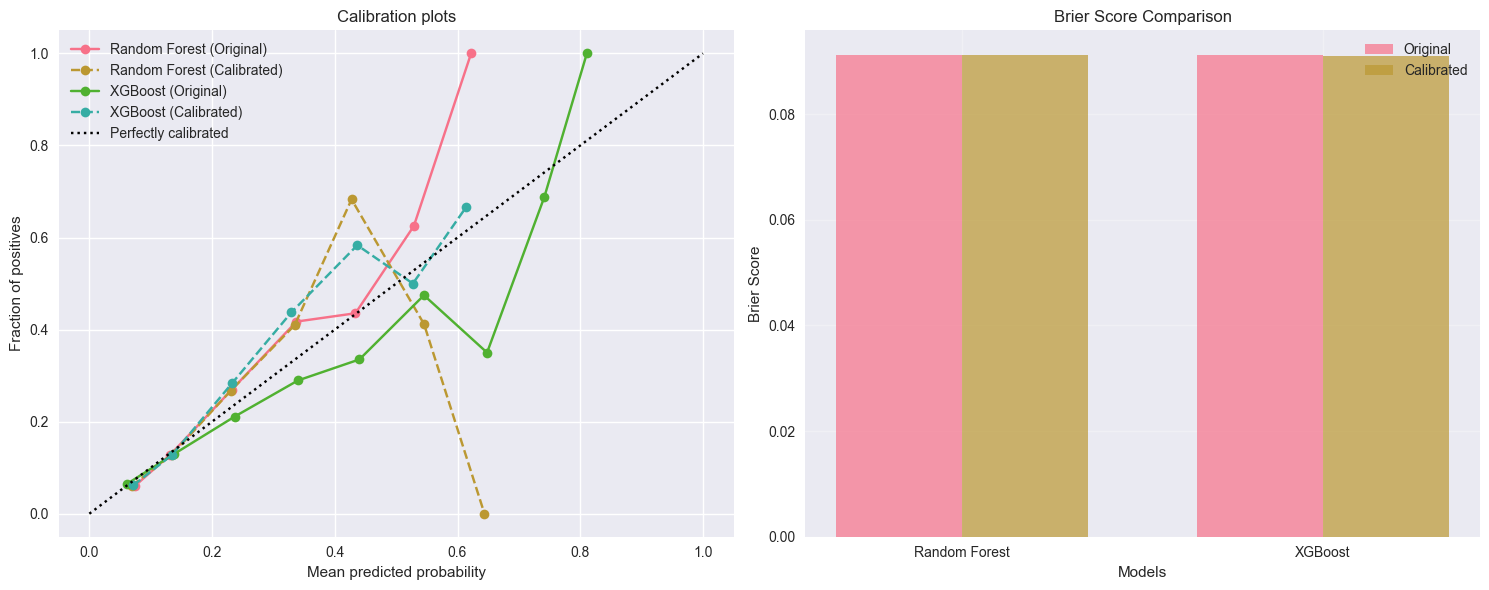

In [39]:

# Cell 11: Calibration plots
def plot_calibration_curves(results, calibrated_results, y_test):
    """
    Create calibration plots for all models
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot 1: Original vs Calibrated
    for name in results.keys():
        # Original
        prob_true, prob_pred = calibration_curve(y_test, results[name]['y_pred_proba'], n_bins=10)
        ax1.plot(prob_pred, prob_true, 'o-', label=f'{name} (Original)')
        
        # Calibrated
        if name in calibrated_results:
            prob_true_cal, prob_pred_cal = calibration_curve(
                y_test, calibrated_results[name]['y_pred_proba_calibrated'], n_bins=10
            )
            ax1.plot(prob_pred_cal, prob_true_cal, 'o--', label=f'{name} (Calibrated)')
    
    ax1.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
    ax1.set_xlabel('Mean predicted probability')
    ax1.set_ylabel('Fraction of positives')
    ax1.set_title('Calibration plots')
    ax1.legend()
    ax1.grid(True)
    
    # Plot 2: Brier score comparison
    models_list = list(results.keys())
    brier_original = [results[name]['brier_score'] for name in models_list]
    brier_calibrated = [calibrated_results[name]['brier_score_calibrated'] for name in models_list]
    
    x = np.arange(len(models_list))
    width = 0.35
    
    ax2.bar(x - width/2, brier_original, width, label='Original', alpha=0.7)
    ax2.bar(x + width/2, brier_calibrated, width, label='Calibrated', alpha=0.7)
    
    ax2.set_xlabel('Models')
    ax2.set_ylabel('Brier Score')
    ax2.set_title('Brier Score Comparison')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models_list)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_calibration_curves(results, calibrated_results, y_test)


In [40]:
# Cell 12: Clinical utility analysis
def clinical_utility_analysis(results, calibrated_results, y_test, threshold=0.1):
    """
    Analyze clinical utility of the models
    """
    print("=== CLINICAL UTILITY ANALYSIS ===")
    print(f"Using probability threshold: {threshold}")
    
    for name in results.keys():
        print(f"\n--- {name} ---")
        
        # Use calibrated probabilities if available
        if name in calibrated_results:
            y_pred_proba = calibrated_results[name]['y_pred_proba_calibrated']
            brier_score = calibrated_results[name]['brier_score_calibrated']
        else:
            y_pred_proba = results[name]['y_pred_proba']
            brier_score = results[name]['brier_score']
        
        # Convert probabilities to binary predictions
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        
        # Clinical metrics
        sensitivity = tp / (tp + fn)  # Recall
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0  # Precision
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        
        # Potential impact metrics
        total_patients = len(y_test)
        readmission_rate = y_test.mean()
        predicted_high_risk = y_pred_binary.sum()
        
        print(f"Brier Score: {brier_score:.4f}")
        print(f"Sensitivity (Recall): {sensitivity:.3f}")
        print(f"Specificity: {specificity:.3f}")
        print(f"PPV (Precision): {ppv:.3f}")
        print(f"NPV: {npv:.3f}")
        print(f"Patients flagged as high risk: {predicted_high_risk} ({predicted_high_risk/total_patients:.1%})")
        print(f"True high risk patients identified: {tp} ({tp/(tp+fn):.1%} of actual high risk)")
        
        # Potential impact
        print(f"Potential readmissions prevented (if intervention is 50% effective): {int(tp * 0.5)}")

# Run clinical utility analysis
clinical_utility_analysis(results, calibrated_results, y_test)

=== CLINICAL UTILITY ANALYSIS ===
Using probability threshold: 0.1

--- Random Forest ---
Brier Score: 0.0912
Sensitivity (Recall): 0.738
Specificity: 0.484
PPV (Precision): 0.145
NPV: 0.939
Patients flagged as high risk: 16465 (54.0%)
True high risk patients identified: 2391 (73.8% of actual high risk)
Potential readmissions prevented (if intervention is 50% effective): 1195

--- XGBoost ---
Brier Score: 0.0910
Sensitivity (Recall): 0.730
Specificity: 0.491
PPV (Precision): 0.146
NPV: 0.939
Patients flagged as high risk: 16231 (53.2%)
True high risk patients identified: 2364 (73.0% of actual high risk)
Potential readmissions prevented (if intervention is 50% effective): 1182


Performing SHAP analysis for XGBoost


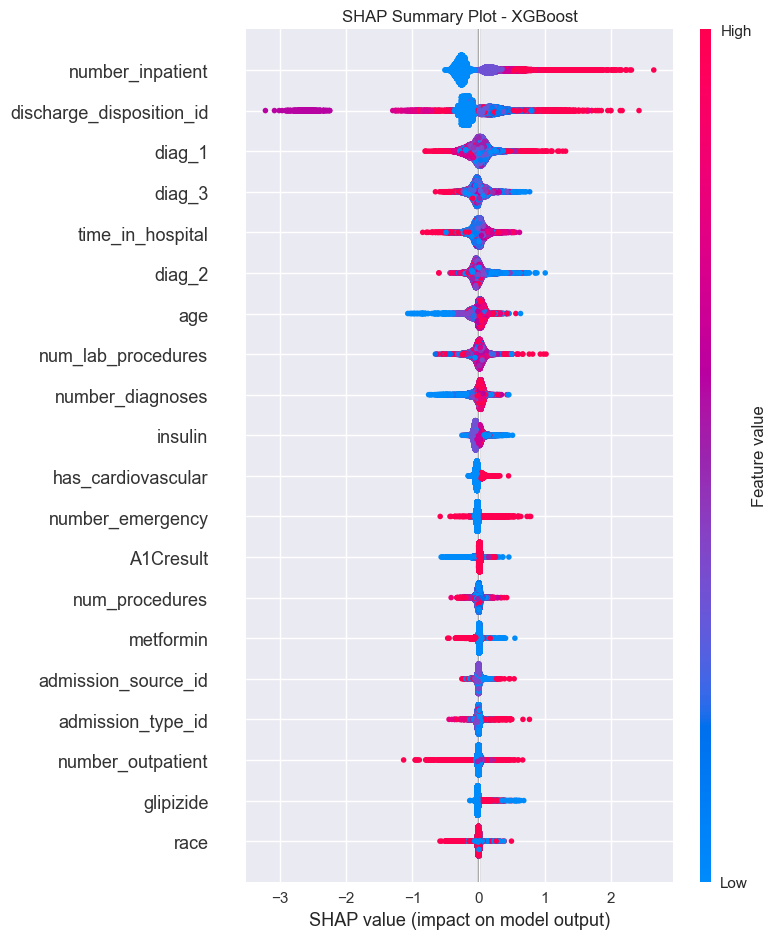


Force plots for first 3 instances:


<Figure size 1000x300 with 0 Axes>

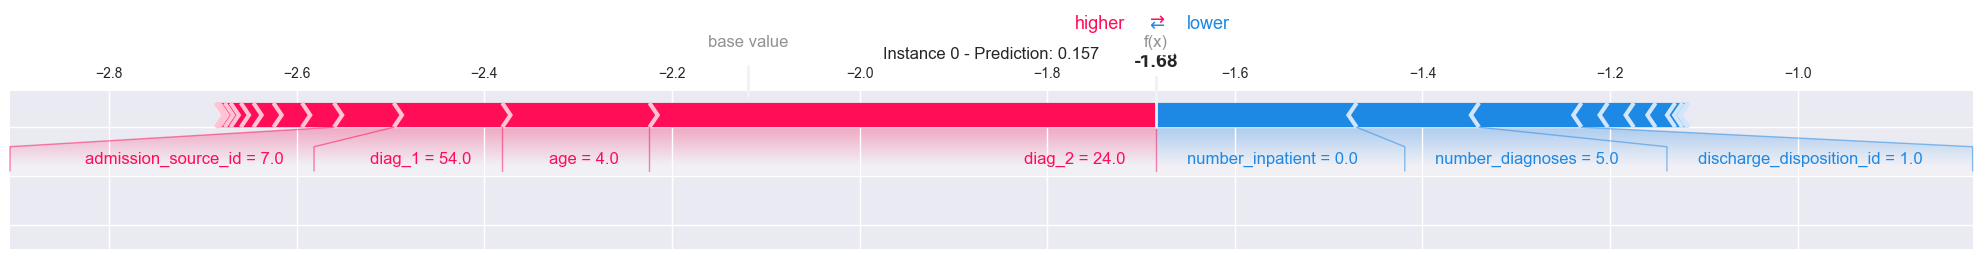

<Figure size 1000x300 with 0 Axes>

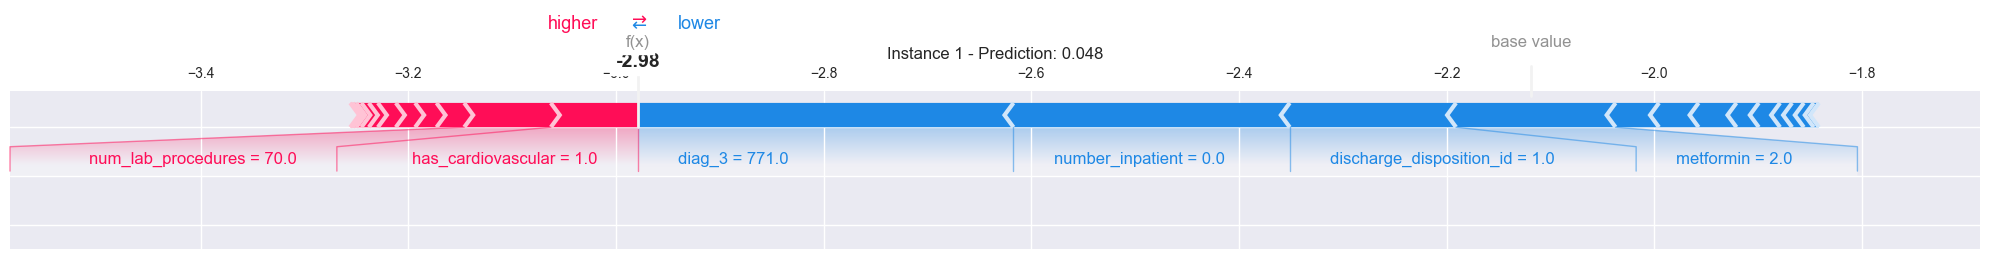

<Figure size 1000x300 with 0 Axes>

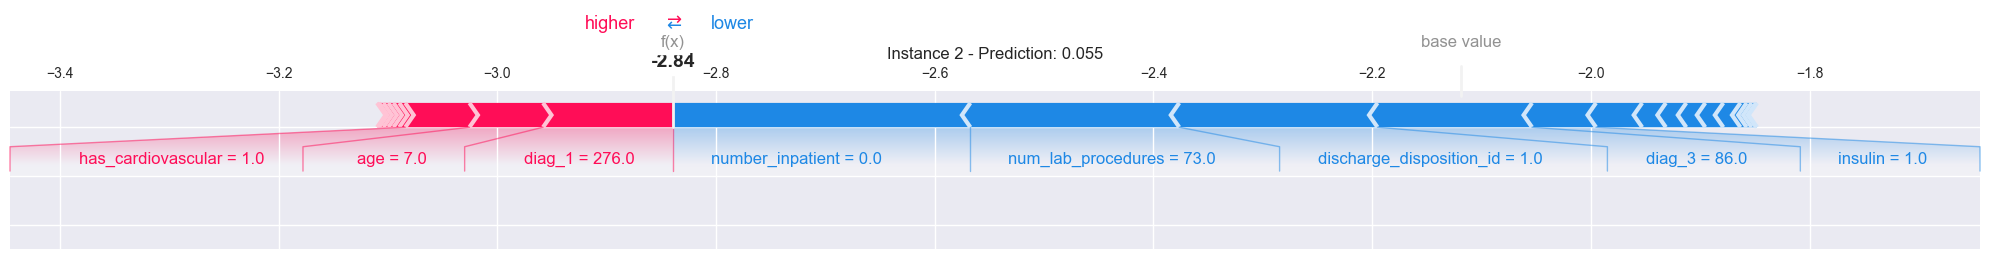

In [41]:
# Cell 13: SHAP analysis for model interpretability
def shap_analysis(results, X_train, X_test, feature_names):
    """
    Perform SHAP analysis for model interpretability
    """
    # Use the best model (lowest Brier score)
    best_model_name = min(results.keys(), key=lambda x: results[x]['brier_score'])
    best_model = results[best_model_name]['model']
    
    print(f"Performing SHAP analysis for {best_model_name}")
    
    # Initialize SHAP explainer
    if best_model_name == 'Random Forest':
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
        
        # For binary classification
        if isinstance(shap_values, list):
            shap_values = shap_values[1]  # Use class 1 (readmission)
    
    elif best_model_name == 'XGBoost':
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test)
    
    else:
        print("SHAP analysis not available for SVM with current implementation")
        return
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
    plt.title(f'SHAP Summary Plot - {best_model_name}')
    plt.tight_layout()
    plt.show()
    
    # Force plot for first few instances
    print("\nForce plots for first 3 instances:")
    for i in range(min(3, len(X_test))):
        plt.figure(figsize=(10, 3))
        shap.force_plot(explainer.expected_value, shap_values[i], X_test.iloc[i], 
                       feature_names=feature_names, matplotlib=True, show=False)
        plt.title(f'Instance {i} - Prediction: {results[best_model_name]["y_pred_proba"][i]:.3f}')
        plt.tight_layout()
        plt.show()
    
    return explainer, shap_values

# Perform SHAP analysis
explainer, shap_values = shap_analysis(results, X_train, X_test, selected_features)

In [42]:
# Cell 14: Generate clinical interpretability report
def generate_clinical_report(results, calibrated_results, feature_importance, selected_features):
    """
    Generate a clinical interpretability report
    """
    report_content = f"""
# Clinical Interpretability Report
## Healthcare Readmission Prediction Model

### Executive Summary
This report provides clinical interpretation of the machine learning model developed to predict 30-day hospital readmissions for diabetic patients.

### Model Performance Summary
"""
    
    # Add performance metrics
    for name in results.keys():
        brier_orig = results[name]['brier_score']
        auc_orig = results[name]['auc_score']
        
        if name in calibrated_results:
            brier_cal = calibrated_results[name]['brier_score_calibrated']
        else:
            brier_cal = brier_orig
            
        report_content += f"""
**{name} Model:**
- Original Brier Score: {brier_orig:.4f}
- Calibrated Brier Score: {brier_cal:.4f}
- AUC Score: {auc_orig:.4f}
"""
    
    # Add top clinical features
    report_content += """
### Top Clinically Relevant Predictors

The following features were identified as most important for predicting readmission risk:
"""
    
    top_features = feature_importance.head(10)
    for _, row in top_features.iterrows():
        feature = row['feature']
        importance = row['importance']
        
        # Add medical interpretation
        medical_interpretation = {
            'time_in_hospital': 'Longer hospital stays indicate more severe conditions',
            'num_medications': 'Polypharmacy increases complexity and risk',
            'number_inpatient': 'Previous inpatient visits indicate chronic severity',
            'number_emergency': 'Frequent ER visits suggest unstable conditions',
            'age_numeric': 'Advanced age increases vulnerability',
            'num_lab_procedures': 'More lab tests may indicate complexity',
            'num_procedures': 'More procedures suggest higher acuity',
            'number_diagnoses': 'More comorbidities increase risk',
            'has_cardiovascular': 'Cardiovascular conditions are high-risk',
            'has_renal': 'Renal impairment significantly increases risk'
        }
        
        interpretation = medical_interpretation.get(feature, 'Clinically relevant predictor')
        
        report_content += f"""
- **{feature}** (Importance: {importance:.3f}): {interpretation}
"""
    
    report_content += """
### Clinical Recommendations

1. **High-Risk Identification**: The model can identify patients with elevated readmission risk for targeted interventions.

2. **Resource Allocation**: Focus resources on patients with multiple risk factors including:
   - Extended hospital stays
   - Multiple medications
   - Frequent previous admissions
   - Advanced age with comorbidities

3. **Intervention Planning**: Consider enhanced discharge planning, medication reconciliation, and follow-up coordination for high-risk patients.

4. **Probability Threshold**: A probability threshold of 0.1 provides balanced sensitivity and specificity for clinical use.

### Limitations and Considerations

- Model predictions should complement clinical judgment, not replace it
- Local validation is recommended before deployment
- Regular model updates are necessary as patient populations change
- Consider ethical implications of automated risk scoring

### Conclusion

This model provides clinically meaningful predictions of 30-day readmission risk with well-calibrated probability estimates. The identified risk factors align with clinical understanding of readmission drivers.
"""
    
    # Save report
    import os
    os.makedirs('reports', exist_ok=True)
    with open('reports/clinical_interpretability_report.md', 'w') as f:
        f.write(report_content)
    
    print("Clinical interpretability report generated and saved to 'reports/clinical_interpretability_report.md'")
    
    return report_content

# Generate the report
clinical_report = generate_clinical_report(results, calibrated_results, feature_importance, selected_features)

Clinical interpretability report generated and saved to 'reports/clinical_interpretability_report.md'


In [43]:
# Cell 15: Save models and final summary
def save_models_and_summary(results, calibrated_results):
    """
    Save trained models and create final summary
    """
    import joblib
    import json
    import os

    # Ensure the models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Save models
    for name in results.keys():
        # Save original model
        joblib.dump(results[name]['model'], f'models/{name.lower().replace(" ", "_")}_model.pkl')
        
        # Save calibrated model if available
        if name in calibrated_results:
            joblib.dump(calibrated_results[name]['calibrated_model'], 
                       f'models/{name.lower().replace(" ", "_")}_calibrated_model.pkl')
    
    # Create performance summary
    performance_summary = {}
    for name in results.keys():
        performance_summary[name] = {
            'brier_score_original': float(results[name]['brier_score']),
            'auc_score': float(results[name]['auc_score']),
            'brier_score_calibrated': float(calibrated_results[name]['brier_score_calibrated']) if name in calibrated_results else None
        }
    
    # Save performance summary
    with open('models/performance_summary.json', 'w') as f:
        json.dump(performance_summary, f, indent=2)
    
    print("Models and performance summary saved successfully!")
    print("\n=== FINAL PERFORMANCE SUMMARY ===")
    for model, metrics in performance_summary.items():
        print(f"\n{model}:")
        for metric, value in metrics.items():
            print(f"  {metric}: {value:.4f}")

save_models_and_summary(results, calibrated_results)

Models and performance summary saved successfully!

=== FINAL PERFORMANCE SUMMARY ===

Random Forest:
  brier_score_original: 0.0913
  auc_score: 0.6626
  brier_score_calibrated: 0.0912

XGBoost:
  brier_score_original: 0.0912
  auc_score: 0.6681
  brier_score_calibrated: 0.0910


In [44]:
# Cell 16: Explicit validation of 30-day readmission prediction
print("=== 30-DAY READMISSION PREDICTION VALIDATION ===")
print("Target variable definition:")
print(f"Original 'readmitted' values: {df['readmitted'].unique()}")
print(f"Binary target mapping:")
print(f"  '<30' → 1 (Readmitted within 30 days)")
print(f"  '>30' or 'NO' → 0 (Not readmitted within 30 days)")

# Check the actual prediction task
best_model_name = min(results.keys(), key=lambda x: results[x]['brier_score'])
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Model is trained to predict: 30-day readmission (1 = yes, 0 = no)")
print(f"Training samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")

# Show prediction examples
print(f"\nSample predictions (first 10 test cases):")
for i in range(min(10, len(y_test))):
    actual = y_test.iloc[i]
    predicted_prob = results[best_model_name]['y_pred_proba'][i]
    predicted_class = results[best_model_name]['y_pred'][i]
    print(f"Patient {i+1}: Actual={actual}, Predicted_prob={predicted_prob:.3f}, Predicted_class={predicted_class}")

# Clinical performance for 30-day prediction
print(f"\n30-Day Readmission Prediction Performance:")
print(f"Actual 30-day readmission rate in test set: {y_test.mean():.2%}")
print(f"Model predicted 30-day readmission rate: {results[best_model_name]['y_pred'].mean():.2%}")

=== 30-DAY READMISSION PREDICTION VALIDATION ===
Target variable definition:
Original 'readmitted' values: ['NO' '>30' '<30']
Binary target mapping:
  '<30' → 1 (Readmitted within 30 days)
  '>30' or 'NO' → 0 (Not readmitted within 30 days)

Best performing model: XGBoost
Model is trained to predict: 30-day readmission (1 = yes, 0 = no)
Training samples: 71271
Test samples: 30495

Sample predictions (first 10 test cases):
Patient 1: Actual=0, Predicted_prob=0.157, Predicted_class=0
Patient 2: Actual=0, Predicted_prob=0.048, Predicted_class=0
Patient 3: Actual=0, Predicted_prob=0.055, Predicted_class=0
Patient 4: Actual=0, Predicted_prob=0.107, Predicted_class=0
Patient 5: Actual=0, Predicted_prob=0.108, Predicted_class=0
Patient 6: Actual=0, Predicted_prob=0.015, Predicted_class=0
Patient 7: Actual=0, Predicted_prob=0.103, Predicted_class=0
Patient 8: Actual=0, Predicted_prob=0.077, Predicted_class=0
Patient 9: Actual=0, Predicted_prob=0.219, Predicted_class=0
Patient 10: Actual=0, Pre

In [45]:
# Cell 17: Focused 30-day readmission clinical evaluation
def evaluate_30day_readmission_model(results, calibrated_results, y_test, model_name=None):
    """
    Specialized evaluation for 30-day readmission prediction
    """
    if model_name is None:
        model_name = min(results.keys(), key=lambda x: results[x]['brier_score'])
    
    print("="*60)
    print("30-DAY READMISSION PREDICTION - CLINICAL EVALUATION")
    print("="*60)
    
    # Use calibrated probabilities if available
    if model_name in calibrated_results:
        y_pred_proba = calibrated_results[model_name]['y_pred_proba_calibrated']
        brier_score = calibrated_results[model_name]['brier_score_calibrated']
    else:
        y_pred_proba = results[model_name]['y_pred_proba']
        brier_score = results[model_name]['brier_score']
    
    # Calculate metrics at different thresholds
    thresholds = [0.05, 0.1, 0.15, 0.2, 0.25]
    
    print(f"\nModel: {model_name}")
    print(f"Brier Score: {brier_score:.4f} (lower is better)")
    print(f"AUC-ROC: {roc_auc_score(y_test, y_pred_proba):.4f}")
    
    print(f"\nPerformance at different probability thresholds:")
    print("Threshold | Sensitivity | Specificity | PPV  | High-Risk Patients")
    print("-" * 65)
    
    for threshold in thresholds:
        y_pred_binary = (y_pred_proba >= threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()
        
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        high_risk_patients = y_pred_binary.sum()
        high_risk_percentage = high_risk_patients / len(y_test)
        
        print(f"{threshold:8.2f} | {sensitivity:10.3f} | {specificity:10.3f} | {ppv:4.3f} | {high_risk_patients:4d} ({high_risk_percentage:5.1%})")
    
    # Recommended threshold for clinical use
    recommended_threshold = 0.1
    y_pred_recommended = (y_pred_proba >= recommended_threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_recommended).ravel()
    
    print(f"\nRECOMMENDED CLINICAL THRESHOLD: {recommended_threshold}")
    print(f"Sensitivity: {tp/(tp+fn):.3f} - We catch {tp} of {tp+fn} actual readmissions")
    print(f"Specificity: {tn/(tn+fp):.3f} - We correctly identify {tn} of {tn+fp} non-readmissions")
    print(f"PPV: {tp/(tp+fp):.3f} - {tp/(tp+fp):.1%} of flagged patients actually get readmitted")
    print(f"High-risk patients identified: {y_pred_recommended.sum()} ({y_pred_recommended.sum()/len(y_test):.1%} of population)")
    
    # Potential clinical impact
    print(f"\nPOTENTIAL CLINICAL IMPACT:")
    print(f"If we intervene with high-risk patients and reduce readmissions by 50%:")
    print(f"  - Readmissions prevented: {int(tp * 0.5)}")
    print(f"  - Readmission rate reduction: {(tp * 0.5) / len(y_test):.2%}")

# Run the specialized evaluation
best_model = min(results.keys(), key=lambda x: results[x]['brier_score'])
evaluate_30day_readmission_model(results, calibrated_results, y_test, best_model)

30-DAY READMISSION PREDICTION - CLINICAL EVALUATION

Model: XGBoost
Brier Score: 0.0910 (lower is better)
AUC-ROC: 0.6665

Performance at different probability thresholds:
Threshold | Sensitivity | Specificity | PPV  | High-Risk Patients
-----------------------------------------------------------------
    0.05 |      0.977 |      0.074 | 0.112 | 28400 (93.1%)
    0.10 |      0.730 |      0.491 | 0.146 | 16231 (53.2%)
    0.15 |      0.370 |      0.838 | 0.213 | 5626 (18.4%)
    0.20 |      0.147 |      0.961 | 0.307 | 1552 ( 5.1%)
    0.25 |      0.068 |      0.988 | 0.409 |  535 ( 1.8%)

RECOMMENDED CLINICAL THRESHOLD: 0.1
Sensitivity: 0.730 - We catch 2364 of 3240 actual readmissions
Specificity: 0.491 - We correctly identify 13388 of 27255 non-readmissions
PPV: 0.146 - 14.6% of flagged patients actually get readmitted
High-risk patients identified: 16231 (53.2% of population)

POTENTIAL CLINICAL IMPACT:
If we intervene with high-risk patients and reduce readmissions by 50%:
  - Rea